# Assignment - Week 2 Shreya Sudhakaran ss18292

# Introduction

Both Adaline and the Perceptron are (single-layer) neural network models. The Perceptron is one of the oldest and simplest learning algorithms out there, and I would consider Adaline as an improvement over the Perceptron.

What Adaline and the Perceptron have in common
they are classifiers for binary classification
both have a linear decision boundary
both can learn iteratively, sample by sample (the Perceptron naturally, and Adaline via stochastic gradient descent)
both use a threshold function
Before we talk about the differences, let’s talk about the inputs first. The first step in the two algorithms is to compute the so-called net input z as the linear combination of our feature variables x and the model weights w.

The Adaline (Adaptive Linear Element) and the Perceptron are both linear classifiers when considered as individual units. They both take an input, and based on a threshold, output e.g. either a 0 or a 1.

The main difference between the two, is that a Perceptron takes that binary response (like a classification result) and computes an error used to update the weights, whereas an Adaline uses a continous response value to update the weights (so before the binarized output is produced).

The fact that the Adaline does this, allows its updates to be more repesentative of the actual error, before it is thresholded, which in turn allows a model to converge more quickly.



In [1]:

%matplotlib inline

import os, math
from IPython.display import Image
import numpy as np
seed = np.random.seed

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Understanding the Iris Data

The Iris dataset is a classic dataset in the field of machine learning and statistics. It is commonly used for demonstrating classification algorithms. Here's a brief explanation:

Source: The Iris dataset was introduced by the British statistician and biologist Ronald Fisher in 1936. It was derived from a 1936 paper titled "The use of multiple measurements in taxonomic problems" by Fisher.

Contents: The dataset contains 150 samples of iris flowers, each with four features: sepal length, sepal width, petal length, and petal width. These features are quantitative measurements in centimeters.

Classes: Each sample in the dataset is labeled with the species of iris it belongs to. There are three classes:

Iris-setosa
Iris-versicolor
Iris-virginica

Structure: The dataset is well-structured and doesn't contain missing values, making it suitable for introductory machine learning tasks.

Overall, the Iris dataset serves as a foundational dataset in the field of machine learning, providing a simple yet effective way to explore classification algorithms and techniques.

In [278]:
df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/'
    'machine-learning-databases/iris/iris.data',
    header = None
)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print('# Training data points: {}'.format(X_train.shape[0]))
print('# Testing data points: {}'.format(X_test.shape[0]))
print('Class labels: {} (mapped from {}'.format(np.unique(y), np.unique(df['Class label'])))

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Training data points: 100
# Testing data points: 50
Class labels: [0 1 2] (mapped from ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [124]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],                                                  
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

# Implementing Perceptron

In [187]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the Perceptron2 class
class Perceptron2(object):
    """Perceptron classifier.
    
    Parameters
    ------------
    eta: float 
        Learning rate (between 0.0 and 1.0)
    n_iter: int
        Number of epochs, i.e., passes over the training dataset.
    random_state : int
        The seed of the pseudo random number generator.
        
    Attributes
    ------------
    w_: 1d-array
        Weights after fitting.
    errors_: list
        Number of misclassifications in every epoch.
    """
    
    def __init__(self, eta=0.01, n_iter=10, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values, or labels.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0.0
            for xi, yi in zip(X, y):
                output = self.predict(xi)
                error = (yi - output)
                self.w_[1:] += self.eta * error * xi
                self.w_[0] += self.eta * error
                errors += int(error != 0.0)
            self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)




## Picking two class of classes of data (i.e., two species of Iris) and two features from the four in the dataset, so that the data for two species are linearly separable 

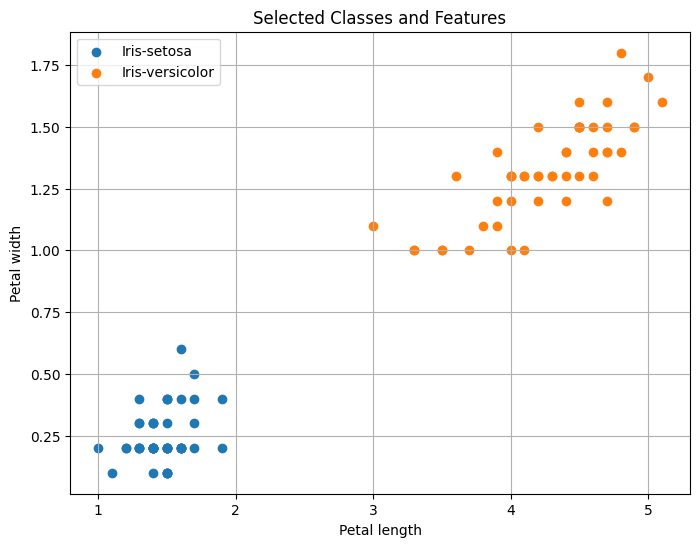

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/'
    'machine-learning-databases/iris/iris.data',
    header=None
)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']

# Selecting two features and two classes
selected_classes = ['Iris-setosa', 'Iris-versicolor']
selected_features = ['Petal length', 'Petal width']

# Filter the dataset for selected classes and features
filtered_df = df[df['Class label'].isin(selected_classes)][['Petal length', 'Petal width', 'Class label']]

# Visualize the data
plt.figure(figsize=(8, 6))
for cls in selected_classes:
    plt.scatter(filtered_df[filtered_df['Class label'] == cls][selected_features[0]], 
                filtered_df[filtered_df['Class label'] == cls][selected_features[1]], 
                label=cls)
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Selected Classes and Features')
plt.legend()
plt.grid(True)
plt.show()


In [128]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-setosa', 'Iris-versicolor'])]

# Selecting features 'Petal length' and 'Petal width'
X = filtered_df[['Petal length', 'Petal width']].values

# Assigning labels 0 for 'Iris-setosa' and 1 for 'Iris-versicolor'
y = pd.factorize(filtered_df['Class label'])[0]
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


In [130]:
# Training
ppn2 = Perceptron2(eta=0.1, n_iter=20)
ppn2.fit(X_train_std, y_train)

# Testing
y_pred = ppn2.predict(X_test_std)

# Calculate misclassified samples
misclassified_samples = (y_test != y_pred).sum()

# Calculate accuracy
accuracy = (y_test == y_pred).mean()

print('Misclassified samples:', misclassified_samples)
print('Accuracy:', accuracy)


Misclassified samples: 3
Accuracy: 0.7


/var/folders/8_/6dnpb6g51x73dzg0q0r9bkdc0000gn/T/ipykernel_26455/1032177424.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


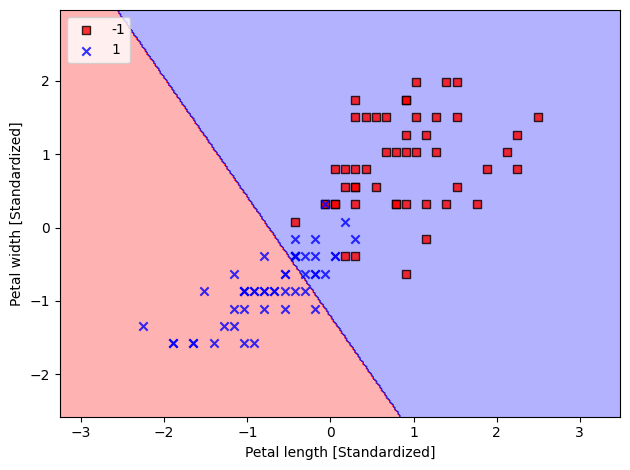

In [131]:

plot_decision_regions(X_combined_std, y_combined, classifier=ppn2)
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



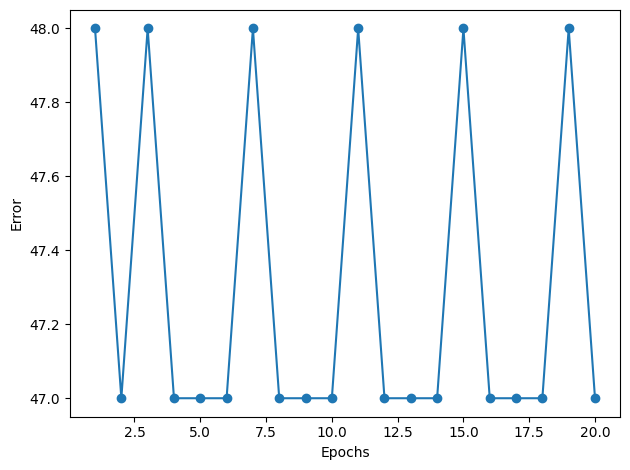

In [132]:
plt.plot(range(1, len(ppn2.errors_) + 1), ppn2.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Error')

plt.tight_layout()
#plt.savefig('./output/fig-perceptron2_errors.png', dpi=300)
plt.show()

## Perceptron - Linear and Three Features

In [280]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-setosa', 'Iris-versicolor'])]

# Selecting features 'Petal length', 'Petal width', and 'Sepal length'
X = filtered_df[['Petal length', 'Petal width', 'Sepal length']].values

# Assigning labels 0 for 'Iris-setosa' and 1 for 'Iris-versicolor'
y = pd.factorize(filtered_df['Class label'])[0]
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


In [281]:
# Training
ppn2 = Perceptron2(eta=0.1, n_iter=20)
ppn2.fit(X_train_std, y_train)

# Testing
y_pred = ppn2.predict(X_test_std)

# Calculate misclassified samples
misclassified_samples = (y_test != y_pred).sum()

# Calculate accuracy
accuracy = (y_test == y_pred).mean()

print('Misclassified samples:', misclassified_samples)
print('Accuracy:', accuracy)


Misclassified samples: 3
Accuracy: 0.7


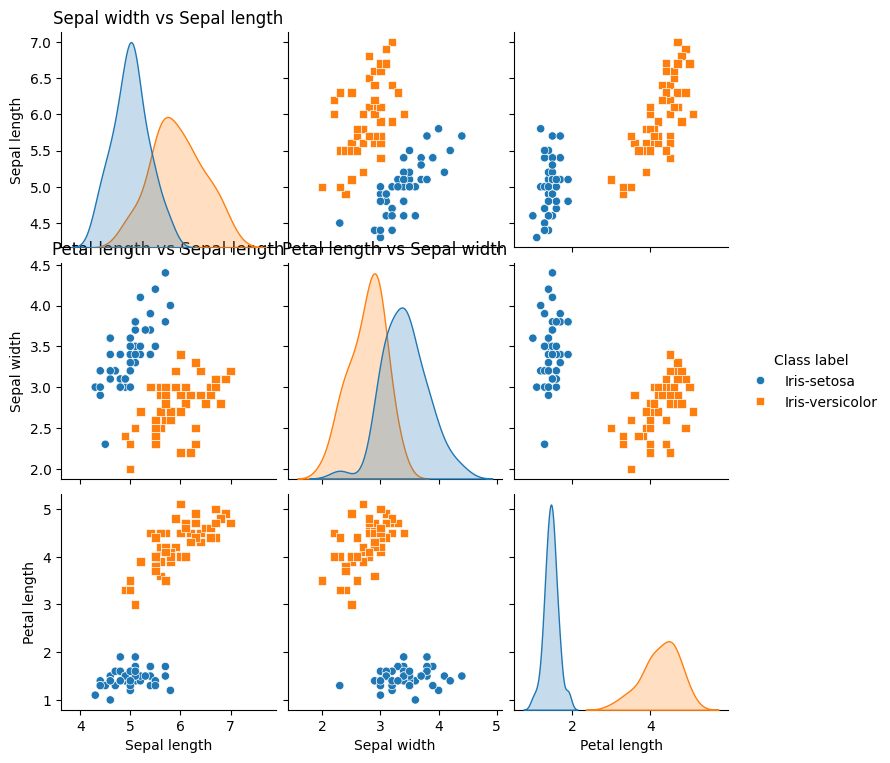

In [282]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Selecting three features and two classes
selected_features = ['Sepal length', 'Sepal width', 'Petal length']
selected_classes = ['Iris-setosa', 'Iris-versicolor']

# Filter the dataset for selected classes and features
filtered_df = df[df['Class label'].isin(selected_classes)][['Sepal length', 'Sepal width', 'Petal length', 'Class label']]

X = filtered_df[selected_features].values

# Assigning labels 0 for 'Iris-setosa' and 1 for 'Iris-versicolor'
y = pd.factorize(filtered_df['Class label'])[0]

# Combine training and test sets for visualization
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# Create pair plots
pairplot = sns.pairplot(filtered_df, hue='Class label', markers=['o', 's'])

# Overlay decision regions on the pair plot
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        ax = pairplot.axes[j-1, i]
        ax.set_title(f"{selected_features[j]} vs {selected_features[i]}")
        #plot_decision_regions(X_combined_std[:, [i, j]], y_combined, classifier=ppn, ax=ax)

plt.show()


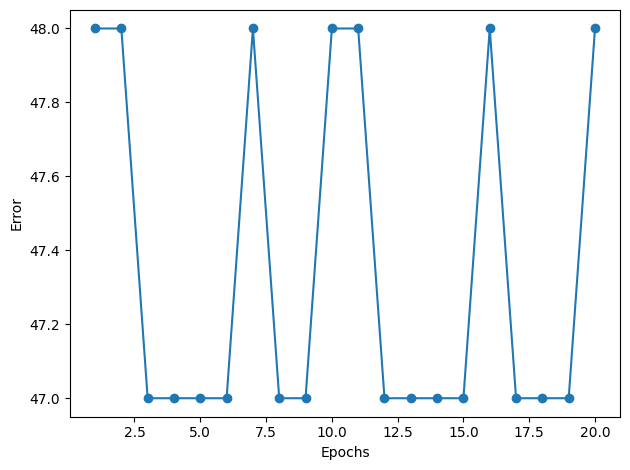

In [283]:
plt.plot(range(1, len(ppn2.errors_) + 1), ppn2.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Error')

plt.tight_layout()
#plt.savefig('./output/fig-perceptron2_errors.png', dpi=300)
plt.show()

## Perceptron Linear - Four Features

In [284]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-setosa', 'Iris-versicolor'])]

# Selecting features 'Petal length', 'Petal width', 'Sepal length', and 'Sepal width'
X = filtered_df[['Petal length', 'Petal width', 'Sepal length', 'Sepal width']].values

# Assigning labels 0 for 'Iris-setosa' and 1 for 'Iris-versicolor'
y = pd.factorize(filtered_df['Class label'])[0]
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


In [285]:
# Training
ppn2 = Perceptron2(eta=0.1, n_iter=20)
ppn2.fit(X_train_std, y_train)

# Testing
y_pred = ppn2.predict(X_test_std)

# Calculate misclassified samples
misclassified_samples = (y_test != y_pred).sum()

# Calculate accuracy
accuracy = (y_test == y_pred).mean()

print('Misclassified samples:', misclassified_samples)
print('Accuracy:', accuracy)


Misclassified samples: 3
Accuracy: 0.7


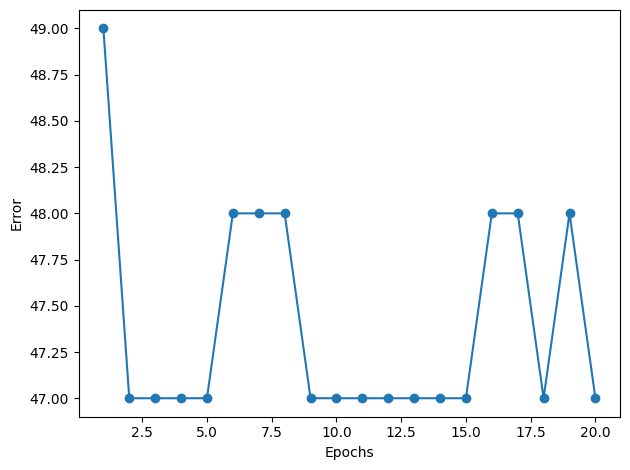

In [286]:
plt.plot(range(1, len(ppn2.errors_) + 1), ppn2.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Error')

plt.tight_layout()
#plt.savefig('./output/fig-perceptron2_errors.png', dpi=300)
plt.show()

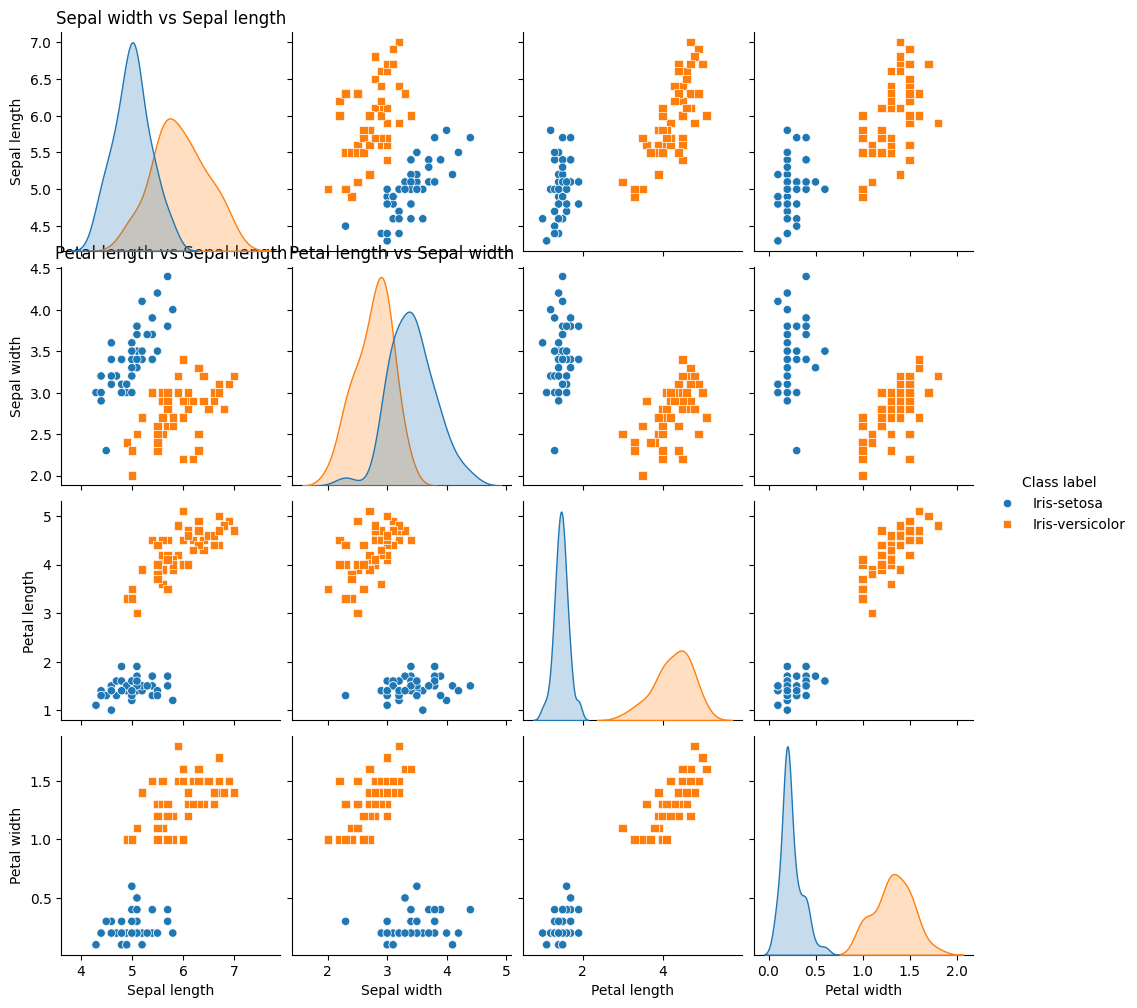

In [287]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



# Combine training and test sets for visualization
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# Create pair plots
pairplot = sns.pairplot(filtered_df, hue='Class label', markers=['o', 's'])

# Overlay decision regions on the pair plot
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        ax = pairplot.axes[j-1, i]
        ax.set_title(f"{selected_features[j]} vs {selected_features[i]}")
        #plot_decision_regions(X_combined_std[:, [i, j]], y_combined, classifier=ppn, ax=ax)

plt.show()


## Pick two classes of data (i.e., two species of Iris) and two features from the four in the dataset, so that the data for two species are NOT linearly separable using the features that you have chosen.

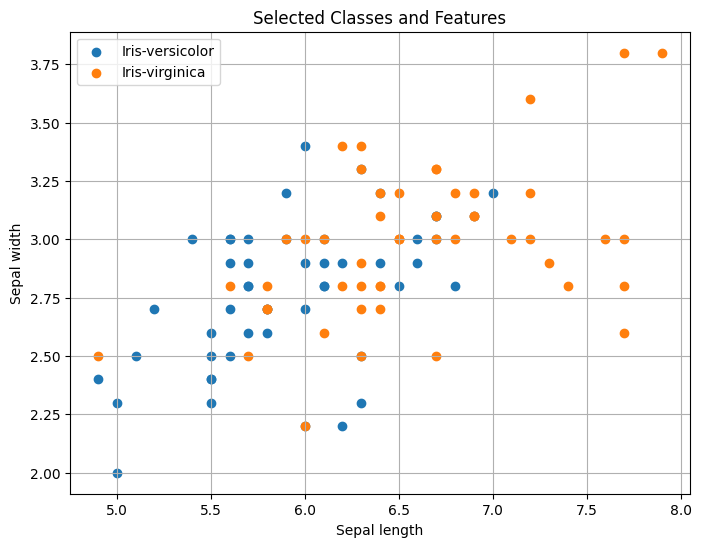

In [31]:
# Selecting two features and two classes
selected_classes = ['Iris-versicolor', 'Iris-virginica']
selected_features = ['Sepal length', 'Sepal width']

# Filter the dataset for selected classes and features
filtered_df = df[df['Class label'].isin(selected_classes)][['Sepal length', 'Sepal width', 'Class label']]

# Visualize the data
plt.figure(figsize=(8, 6))
for cls in selected_classes:
    plt.scatter(filtered_df[filtered_df['Class label'] == cls][selected_features[0]], 
                filtered_df[filtered_df['Class label'] == cls][selected_features[1]], 
                label=cls)
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Selected Classes and Features')
plt.legend()
plt.grid(True)
plt.show()


# Percepton - Non-Linear Two features

In [292]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-versicolor', 'Iris-virginica'])]

# Selecting features 'Petal length' and 'Petal width'
X = filtered_df[['Petal length', 'Petal width']].values

# Assigning labels 0 for 'Iris-versicolor' and 1 for 'Iris-virginica'
y = pd.factorize(filtered_df['Class label'])[0]
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


In [293]:
# Training
ppn2 = Perceptron2(eta=0.1, n_iter=20)
ppn2.fit(X_train_std, y_train)

# Testing
y_pred = ppn2.predict(X_test_std)

# Calculate misclassified samples
misclassified_samples = (y_test != y_pred).sum()

# Calculate accuracy
accuracy = (y_test == y_pred).mean()

print('Misclassified samples:', misclassified_samples)
print('Accuracy:', accuracy)


Misclassified samples: 4
Accuracy: 0.6


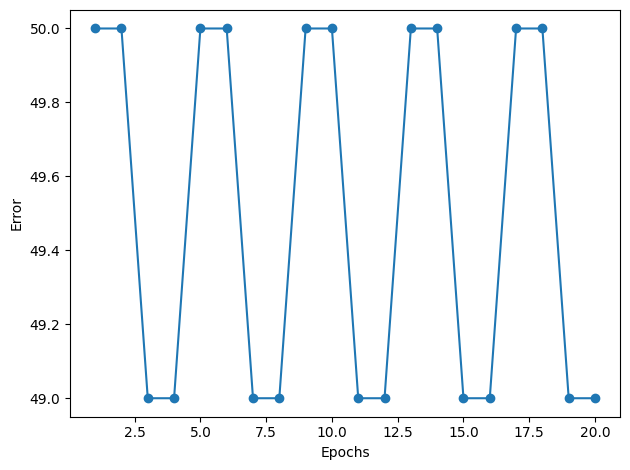

In [294]:
plt.plot(range(1, len(ppn2.errors_) + 1), ppn2.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Error')

plt.tight_layout()
#plt.savefig('./output/fig-perceptron2_errors.png', dpi=300)
plt.show()

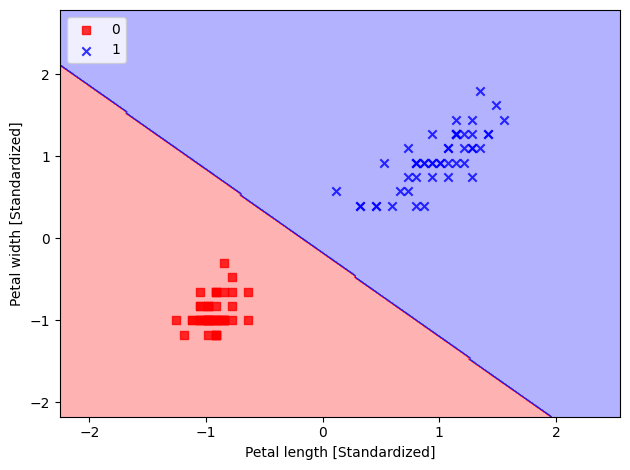

In [295]:

plot_decision_regions(X_combined_std, y_combined, classifier=ppn2)
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



## Perceptron Non-Linear Three Features

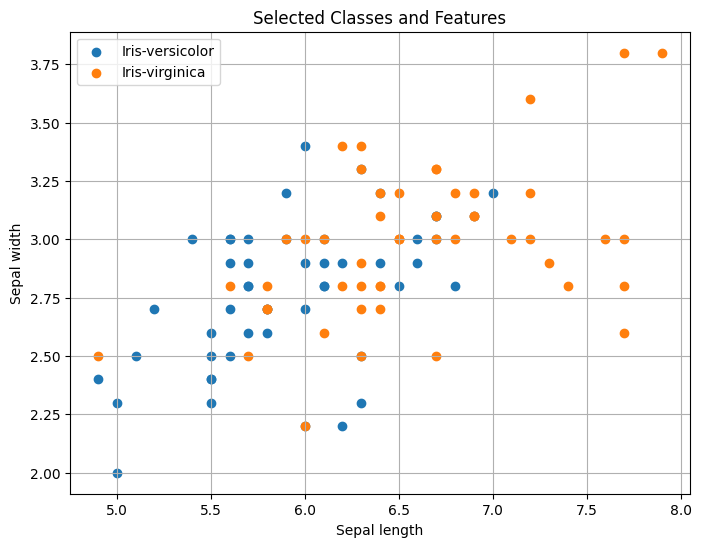

# Training data points: 90
# Testing data points: 10
Class labels: [-1  1]


In [215]:
# Selecting three features and two classes
selected_features = ['Sepal length', 'Sepal width', 'Petal length']
selected_classes = ['Iris-versicolor', 'Iris-virginica']

# Filter the dataset for selected classes and features
filtered_df = df[df['Class label'].isin(selected_classes)][['Sepal length', 'Sepal width', 'Petal length', 'Class label']]

# Visualize the data
plt.figure(figsize=(8, 6))
for cls in selected_classes:
    plt.scatter(filtered_df[filtered_df['Class label'] == cls][selected_features[0]], 
                filtered_df[filtered_df['Class label'] == cls][selected_features[1]], 
                label=cls)
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Selected Classes and Features')
plt.legend()
plt.grid(True)
plt.show()

# Ensure we only take the first 100 samples (50 each for the selected classes)
X = filtered_df[selected_features].values[:100]
y = np.where(filtered_df['Class label'].values[:100] == 'Iris-virginica', 1, -1)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


In [355]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-versicolor', 'Iris-virginica'])]

# Selecting features 'Petal length', 'Petal width', and 'Sepal width'
X = filtered_df[['Petal length', 'Petal width', 'Sepal width']].values

# Assigning labels 0 for 'Iris-versicolor' and 1 for 'Iris-virginica'
y = pd.factorize(filtered_df['Class label'])[0]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


In [356]:
# Training
ppn2 = Perceptron2(eta=0.1, n_iter=20)
ppn2.fit(X_train_std, y_train)

# Testing
y_pred = ppn2.predict(X_test_std)

# Calculate misclassified samples
misclassified_samples = (y_test != y_pred).sum()

# Calculate accuracy
accuracy = (y_test == y_pred).mean()

print('Misclassified samples:', misclassified_samples)
print('Accuracy:', accuracy)


Misclassified samples: 8
Accuracy: 0.2


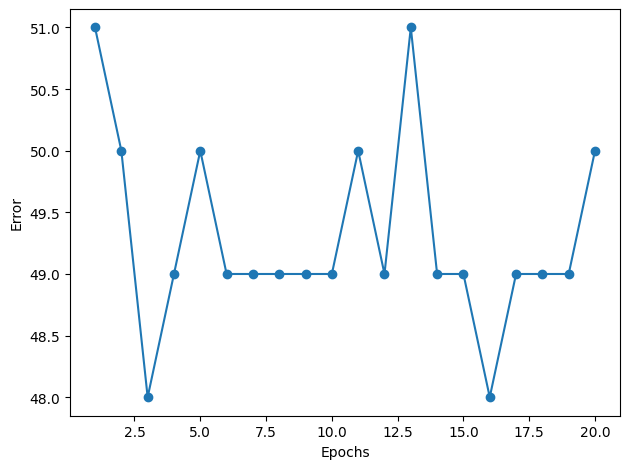

In [298]:
plt.plot(range(1, len(ppn2.errors_) + 1), ppn2.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Error')

plt.tight_layout()
#plt.savefig('./output/fig-perceptron2_errors.png', dpi=300)
plt.show()

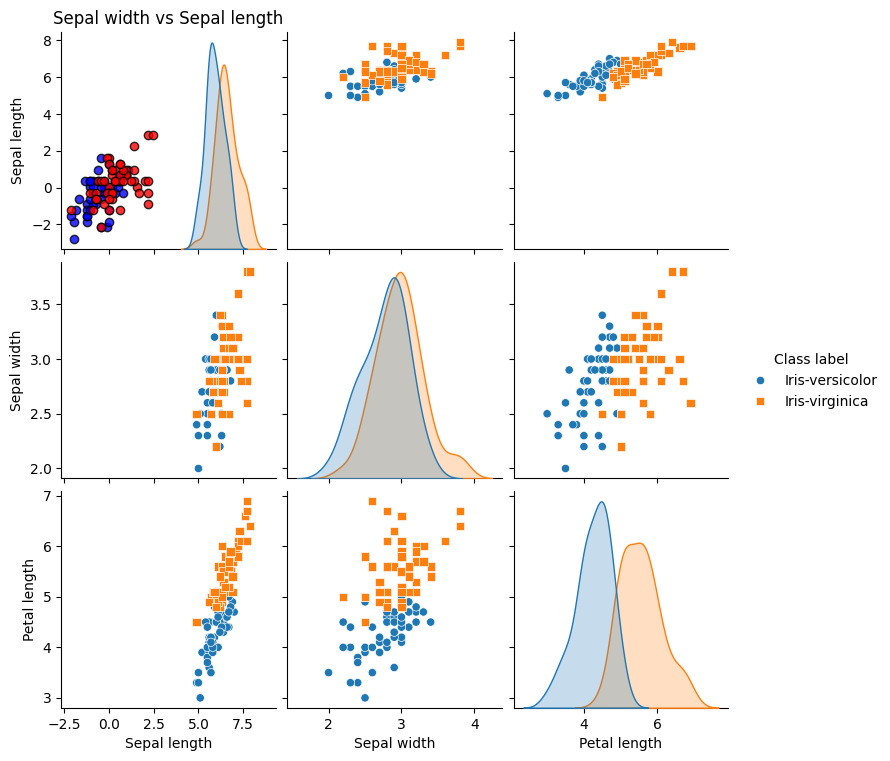

In [299]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron

# Assuming df, selected_features, filtered_df_versicolor, and filtered_df_virginica are defined as in your code

# Combine filtered dataframes
filtered_df = pd.concat([filtered_df_versicolor, filtered_df_virginica])

# Extracting features and labels
X = filtered_df[selected_features].values
y = pd.factorize(filtered_df['Class label'])[0]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Standardizing the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Train the perceptron classifiers
ppn_versicolor = Perceptron(eta0=0.1, random_state=1)
ppn_versicolor.fit(X_train_std, y_train)

ppn_virginica = Perceptron(eta0=0.1, random_state=1)
ppn_virginica.fit(X_train_std, y_train)

# Combine training and test sets for visualization
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# Create pair plot
pairplot = sns.pairplot(filtered_df, hue='Class label', markers=['o', 's'])

# Overlay decision boundaries and scatter plots
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        ax = pairplot.axes[j-1, i]
        ax.set_title(f"{selected_features[j]} vs {selected_features[i]}")

        # Plot decision regions and scatter plot for 'Iris-versicolor'
        h = .02  # step size in the mesh
        x_min, x_max = X_combined_std[:, i].min() - 1, X_combined_std[:, i].max() + 1
        y_min, y_max = X_combined_std[:, j].min() - 1, X_combined_std[:, j].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        #Z_versicolor = ppn_versicolor.predict(np.array([xx.ravel(), yy.ravel()]).T)
        #Z_versicolor = Z_versicolor.reshape(xx.shape)
        #ax.contourf(xx, yy, Z_versicolor, alpha=0.3, colors=['blue'])
        ax.scatter(X_combined_std[y_combined == 0, i], X_combined_std[y_combined == 0, j], c='blue', edgecolor='k', alpha=0.8)

        # Plot decision regions and scatter plot for 'Iris-virginica'
        #Z_virginica = ppn_virginica.predict(np.array([xx.ravel(), yy.ravel()]).T)
        #Z_virginica = Z_virginica.reshape(xx.shape)
        #ax.contourf(xx, yy, Z_virginica, alpha=0.3, colors=['red'])
        ax.scatter(X_combined_std[y_combined == 1, i], X_combined_std[y_combined == 1, j], c='red', edgecolor='k', alpha=0.8)

plt.show()


## Perceptron Non - Linear Four Features

In [353]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-versicolor', 'Iris-virginica'])]

# Selecting features 'Petal length', 'Petal width', 'Sepal length', and 'Sepal width'
X = filtered_df[['Petal length', 'Petal width', 'Sepal length', 'Sepal width']].values

# Assigning labels 0 for 'Iris-versicolor' and 1 for 'Iris-virginica'
y = pd.factorize(filtered_df['Class label'])[0]


# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


In [354]:
# Training
ppn2 = Perceptron2(eta=0.1, n_iter=20)
ppn2.fit(X_train_std, y_train)

# Testing
y_pred = ppn2.predict(X_test_std)

# Calculate misclassified samples
misclassified_samples = (y_test != y_pred).sum()

# Calculate accuracy
accuracy = (y_test == y_pred).mean()

print('Misclassified samples:', misclassified_samples)
print('Accuracy:', accuracy)


Misclassified samples: 9
Accuracy: 0.1


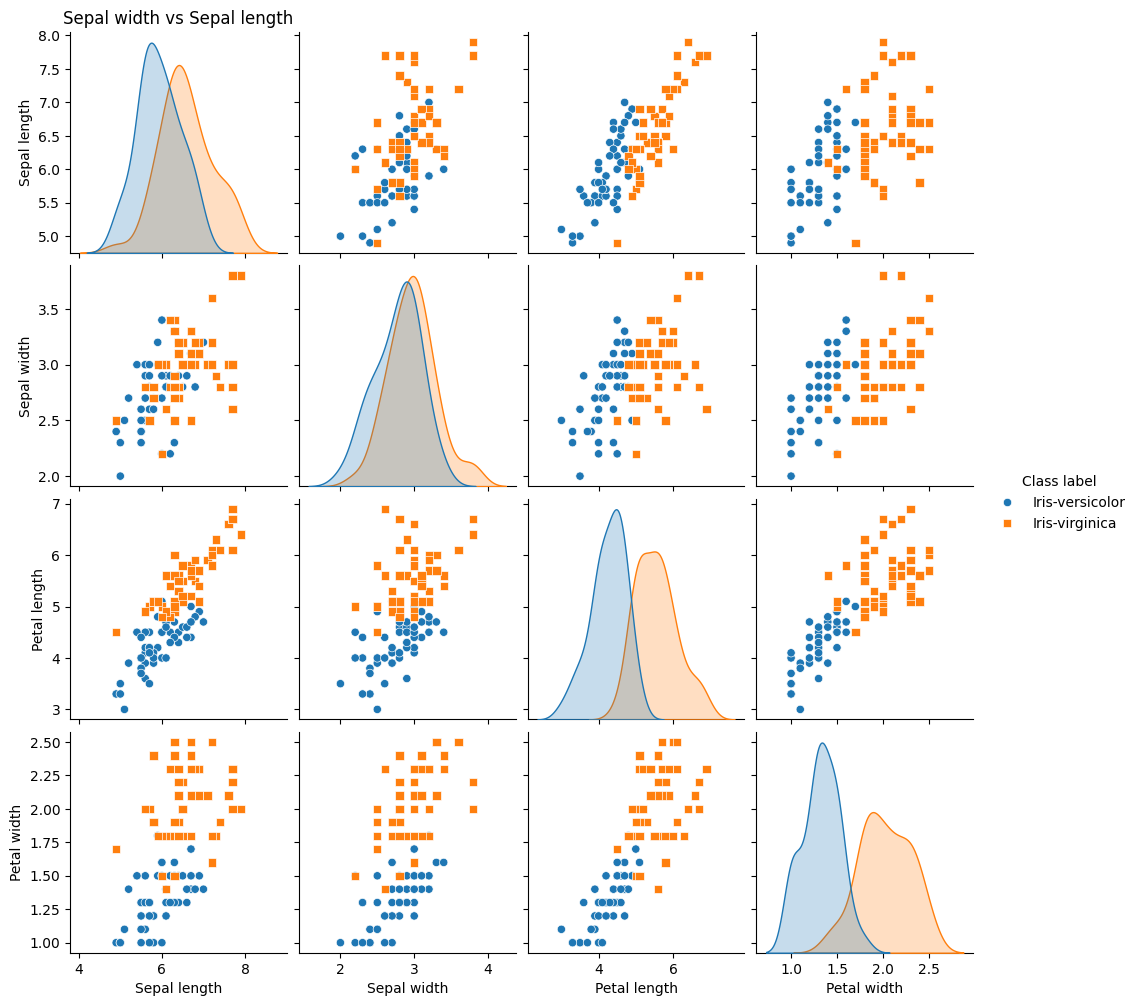

In [302]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



# Combine training and test sets for visualization
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# Create pair plots
pairplot = sns.pairplot(filtered_df, hue='Class label', markers=['o', 's'])

# Overlay decision regions on the pair plot
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        ax = pairplot.axes[j-1, i]
        ax.set_title(f"{selected_features[j]} vs {selected_features[i]}")
        #plot_decision_regions(X_combined_std[:, [i, j]], y_combined, classifier=ppn, ax=ax)

plt.show()


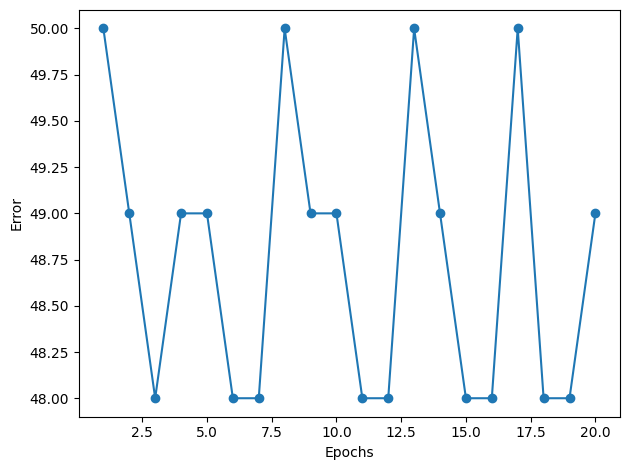

In [303]:
plt.plot(range(1, len(ppn2.errors_) + 1), ppn2.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Error')

plt.tight_layout()
#plt.savefig('./output/fig-perceptron2_errors.png', dpi=300)
plt.show()

# Implementing Adaline Model

In [246]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        The seed of the pseudo random number generator.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.activation(X)
            
            # Cost function
            error = (y - output)
            cost = (error**2).sum() / 2.0
            self.cost_.append(cost)
            
            # Update rule
            self.w_[1:] += self.eta * X.T.dot(error)
            self.w_[0] += self.eta * error.sum()
            
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

### Pick two classes of data (i.e., two species of Iris) and two features from the four in the dataset, so that the data for two species are linearly separable using the features that you have chosen.

In [305]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-setosa', 'Iris-versicolor'])]

# Selecting features 'Petal length' and 'Petal width'
X = filtered_df[['Petal length', 'Petal width']].values

# Assigning labels 0 for 'Iris-setosa' and 1 for 'Iris-versicolor'
y = pd.factorize(filtered_df['Class label'])[0]
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


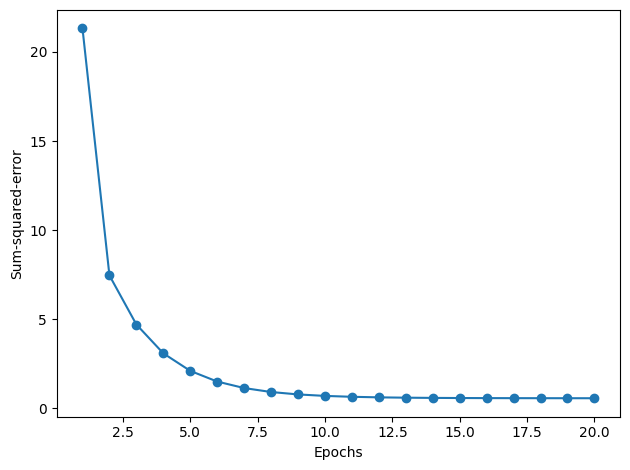

Misclassified samples: 3
Accuracy: 0.70


In [306]:
ada = AdalineGD(n_iter=20, eta=0.01)
ada.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
#plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()

# testing accuracy

y_pred = ada.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))



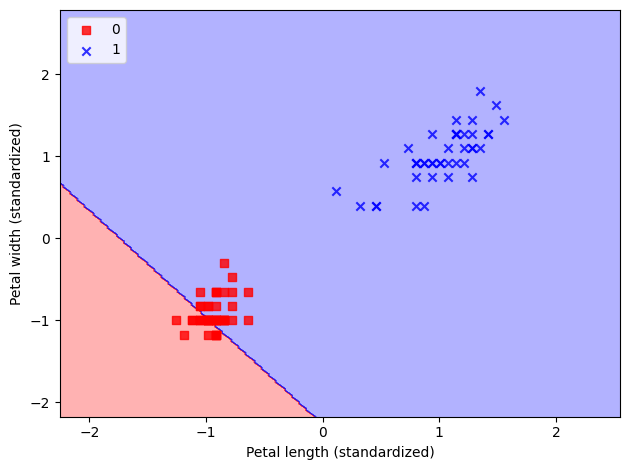

In [307]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=[cmap(idx)],
                    marker=markers[idx], label=cl)

plot_decision_regions(X_train_std, y_train, classifier=ada)
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


## Adaline Linear - Three Features

In [369]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-setosa', 'Iris-versicolor'])]

# Selecting features 'Petal length', 'Petal width', and 'Sepal length'
X = filtered_df[['Petal length', 'Petal width', 'Sepal length']].values

# Assigning labels 0 for 'Iris-setosa' and 1 for 'Iris-versicolor'
y = pd.factorize(filtered_df['Class label'])[0]
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


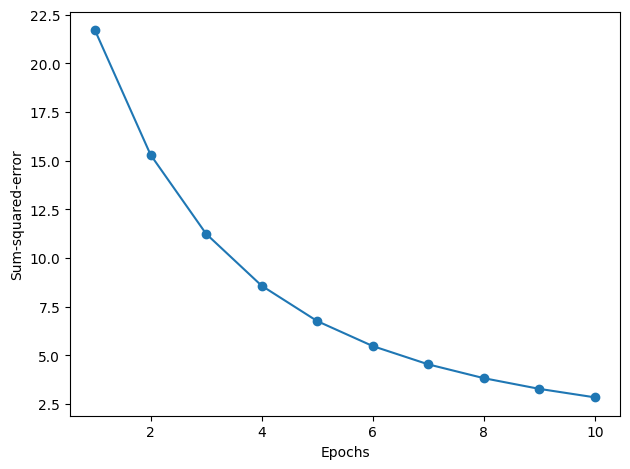

Misclassified samples: 3
Accuracy: 0.70


In [370]:
ada = AdalineGD(n_iter=10, eta=0.001)
ada.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
#plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()

# testing accuracy

y_pred = ada.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))


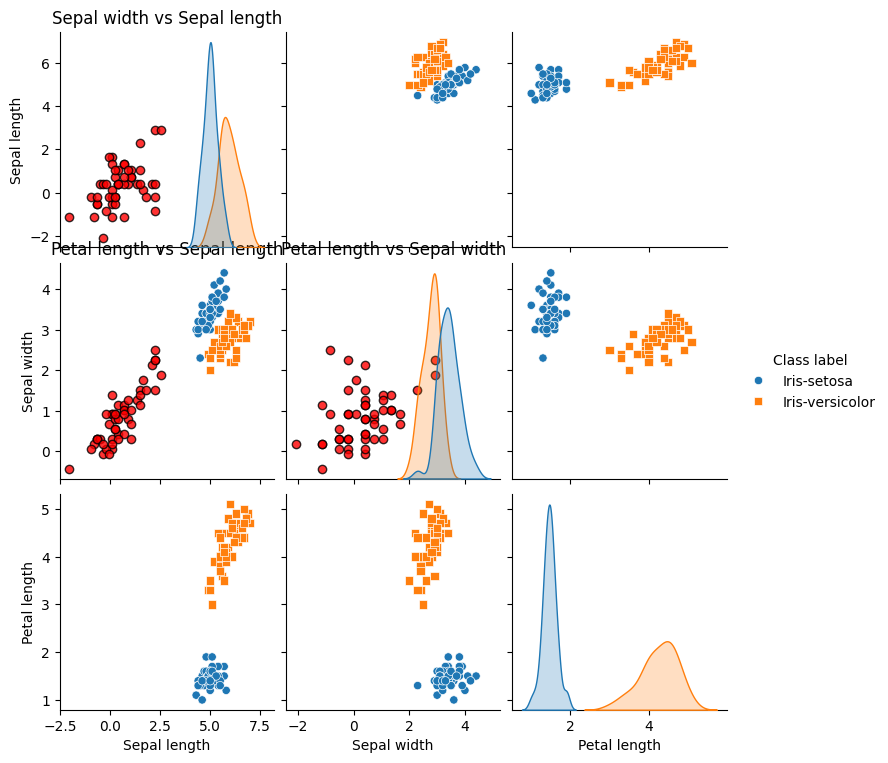

In [257]:
# Create pair plot
pairplot = sns.pairplot(filtered_df, hue='Class label', markers=['o', 's'])

# Overlay decision boundaries and scatter plots
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        ax = pairplot.axes[j-1, i]
        ax.set_title(f"{selected_features[j]} vs {selected_features[i]}")

        # Plot decision regions and scatter plot
        h = .02  # step size in the mesh
        x_min, x_max = X_combined_std[:, i].min() - 1, X_combined_std[:, i].max() + 1
        y_min, y_max = X_combined_std[:, j].min() - 1, X_combined_std[:, j].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        #Z = ada.predict(np.array([xx.ravel(), yy.ravel()]).T)
        #Z = Z.reshape(xx.shape)
        #ax.contourf(xx, yy, Z, alpha=0.3, colors=['blue', 'red'])

        ax.scatter(X_combined_std[y_combined == 0, i], X_combined_std[y_combined == 0, j], c='blue', edgecolor='k', alpha=0.8)
        ax.scatter(X_combined_std[y_combined == 1, i], X_combined_std[y_combined == 1, j], c='red', edgecolor='k', alpha=0.8)

plt.show()

## Adaline Linear - four features

In [366]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-setosa', 'Iris-versicolor'])]

# Selecting features 'Petal length', 'Petal width', 'Sepal length', and 'Sepal width'
X = filtered_df[['Petal length', 'Petal width', 'Sepal length', 'Sepal width']].values

# Assigning labels 0 for 'Iris-setosa' and 1 for 'Iris-versicolor'
y = pd.factorize(filtered_df['Class label'])[0]
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


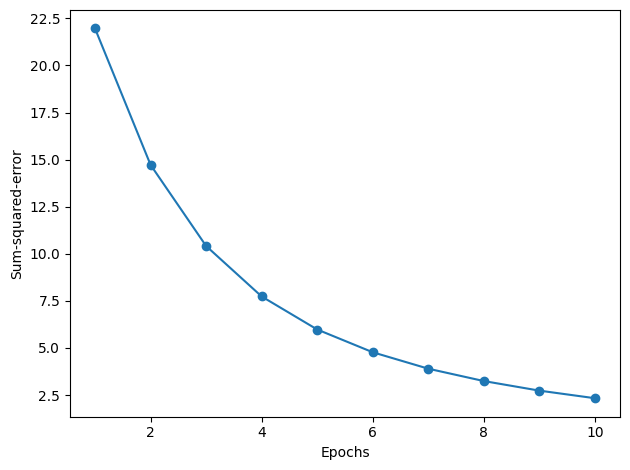

Misclassified samples: 3
Accuracy: 0.70


In [367]:
ada = AdalineGD(n_iter=10, eta=0.001)
ada.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
#plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()

# testing accuracy

y_pred = ada.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))


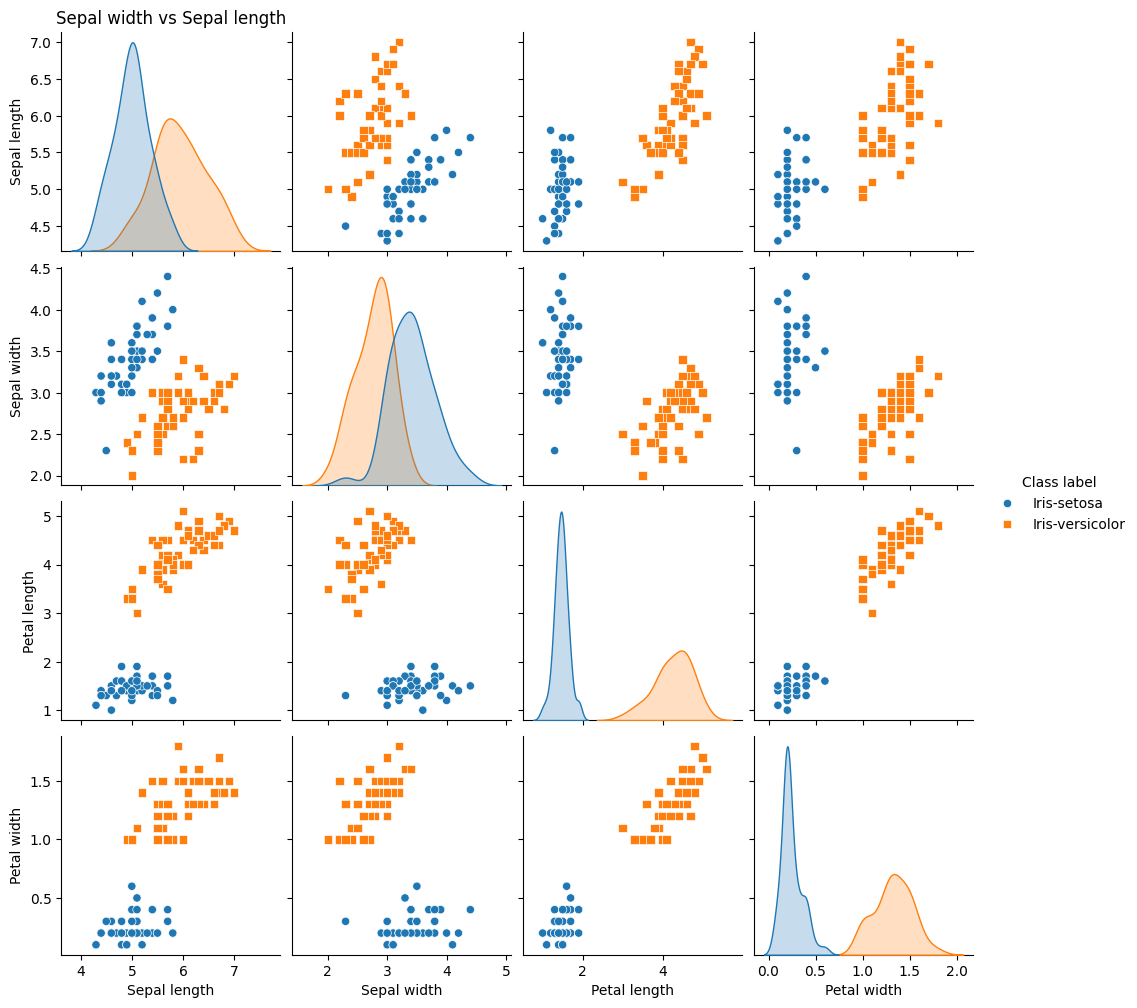

In [314]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



# Combine training and test sets for visualization
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# Create pair plots
pairplot = sns.pairplot(filtered_df, hue='Class label', markers=['o', 's'])

# Overlay decision regions on the pair plot
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        ax = pairplot.axes[j-1, i]
        ax.set_title(f"{selected_features[j]} vs {selected_features[i]}")
        #plot_decision_regions(X_combined_std[:, [i, j]], y_combined, classifier=ppn, ax=ax)

plt.show()


## Pick two classes of data (i.e., two species of Iris) and two features from the four in the dataset, so that the data for two species are NOT linearly separable using the features that you have chosen.

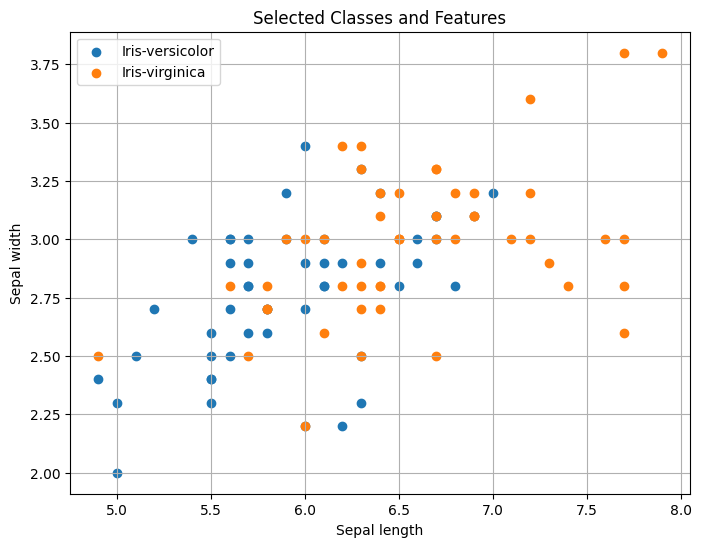

In [59]:
# Selecting two features and two classes
selected_classes = ['Iris-versicolor', 'Iris-virginica']
selected_features = ['Sepal length', 'Sepal width']

# Filter the dataset for selected classes and features
filtered_df = df[df['Class label'].isin(selected_classes)][['Sepal length', 'Sepal width', 'Class label']]

# Visualize the data
plt.figure(figsize=(8, 6))
for cls in selected_classes:
    plt.scatter(filtered_df[filtered_df['Class label'] == cls][selected_features[0]], 
                filtered_df[filtered_df['Class label'] == cls][selected_features[1]], 
                label=cls)
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Selected Classes and Features')
plt.legend()
plt.grid(True)
plt.show()


## Adaline Non-Linear Two Features

In [351]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-versicolor', 'Iris-virginica'])]

# Selecting features 'Petal length' and 'Petal width'
X = filtered_df[['Petal length', 'Petal width']].values

# Assigning labels 0 for 'Iris-versicolor' and 1 for 'Iris-virginica'
y = pd.factorize(filtered_df['Class label'])[0]
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


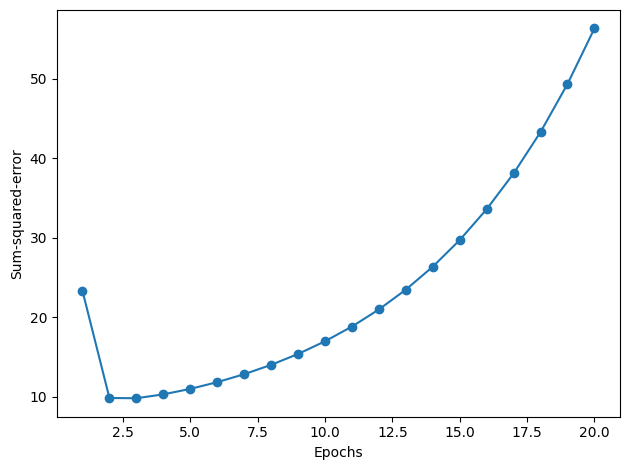

Misclassified samples: 6
Accuracy: 0.40


In [352]:
ada = AdalineGD(n_iter=20, eta=0.01)
ada.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
#plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()

# testing accuracy

y_pred = ada.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))


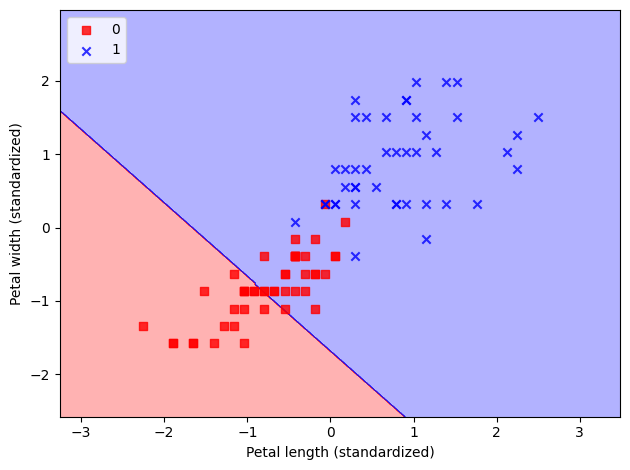

In [378]:
# Import necessary libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel(), np.zeros_like(xx1.ravel())]).T)  # Use the first two features
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=[cmap(idx)],
                    marker=markers[idx], label=cl)

# Assuming ada is your trained Adaline model
plot_decision_regions(X_train_std[:, :2], y_train, classifier=ada)
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


### Adaline Non - Linear three features

In [317]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-versicolor', 'Iris-virginica'])]

# Selecting features 'Petal length', 'Petal width', and 'Sepal length'
X = filtered_df[['Petal length', 'Petal width', 'Sepal length']].values

# Assigning labels 0 for 'Iris-versicolor' and 1 for 'Iris-virginica'
y = pd.factorize(filtered_df['Class label'])[0]
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


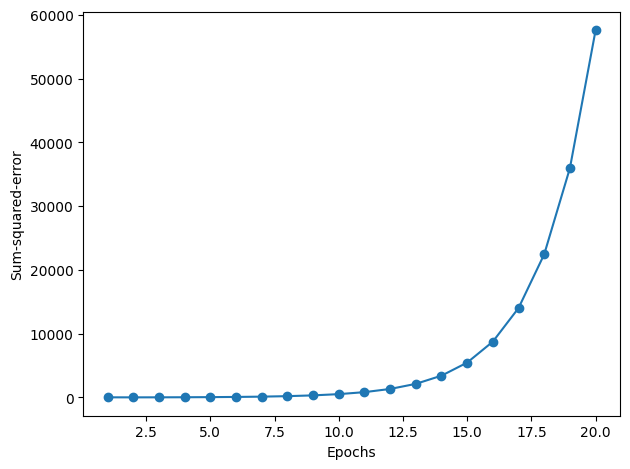

Misclassified samples: 9
Accuracy: 0.10


In [318]:
ada = AdalineGD(n_iter=20, eta=0.01)
ada.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
#plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()

# testing accuracy

y_pred = ada.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))


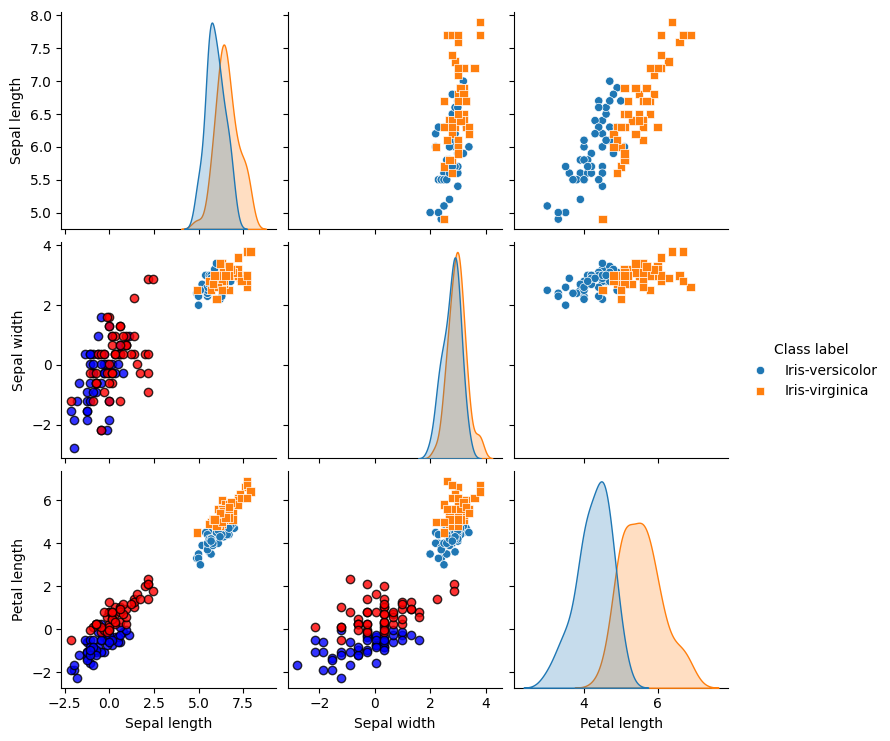

In [270]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from adalinegd import AdalineGD  # Assuming you have AdalineGD class defined

# Assuming df, selected_features, filtered_df_versicolor, and filtered_df_virginica are defined as in your code

# Combine filtered dataframes
filtered_df = pd.concat([filtered_df_versicolor, filtered_df_virginica])

# Ensure all selected features are present in the DataFrame
selected_features = [feature for feature in selected_features if feature in filtered_df.columns]

# Extracting features and labels
X = filtered_df[selected_features].values
y = pd.factorize(filtered_df['Class label'])[0]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Standardizing the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Train the AdalineGD classifier
ada = AdalineGD(n_iter=20, eta=0.01)
ada.fit(X_train_std, y_train)

# Combine training and test sets for visualization
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# Create pair plot
pairplot = sns.pairplot(filtered_df, hue='Class label', markers=['o', 's'])

# Overlay decision boundaries and scatter plots
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        ax = pairplot.axes[j, i]

        # Plot decision regions and scatter plot
        h = .02  # step size in the mesh
        x_min, x_max = X_combined_std[:, i].min() - 1, X_combined_std[:, i].max() + 1
        y_min, y_max = X_combined_std[:, j].min() - 1, X_combined_std[:, j].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        #Z = ada.predict(np.array([xx.ravel(), yy.ravel(), 
                                  #np.zeros_like(xx.ravel()), np.zeros_like(xx.ravel())]).T)
        #Z = Z.reshape(xx.shape)
        #ax.contourf(xx, yy, Z, alpha=0.3, colors=['blue', 'red'])

        ax.scatter(X_combined_std[y_combined == 0, i], X_combined_std[y_combined == 0, j], c='blue', edgecolor='k', alpha=0.8)
        ax.scatter(X_combined_std[y_combined == 1, i], X_combined_std[y_combined == 1, j], c='red', edgecolor='k', alpha=0.8)

plt.show()


### Adaline Non-Linear Four Features

In [319]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-versicolor', 'Iris-virginica'])]

# Selecting features 'Petal length', 'Petal width', 'Sepal length', and 'Sepal width'
X = filtered_df[['Petal length', 'Petal width', 'Sepal length', 'Sepal width']].values

# Assigning labels 0 for 'Iris-versicolor' and 1 for 'Iris-virginica'
y = pd.factorize(filtered_df['Class label'])[0]
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


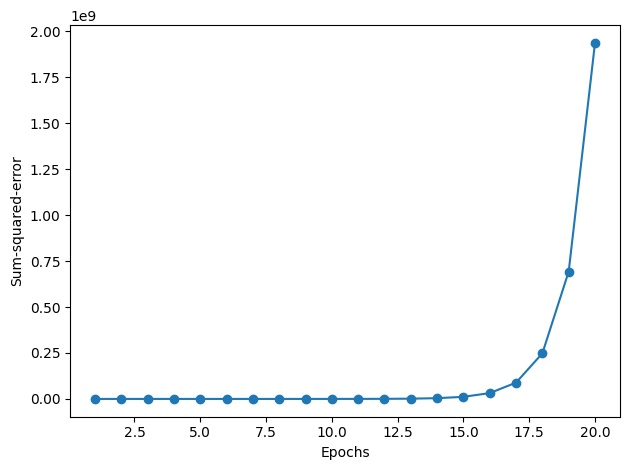

Misclassified samples: 8
Accuracy: 0.20


In [320]:
ada = AdalineGD(n_iter=20, eta=0.01)
ada.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
#plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()

# testing accuracy

y_pred = ada.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))


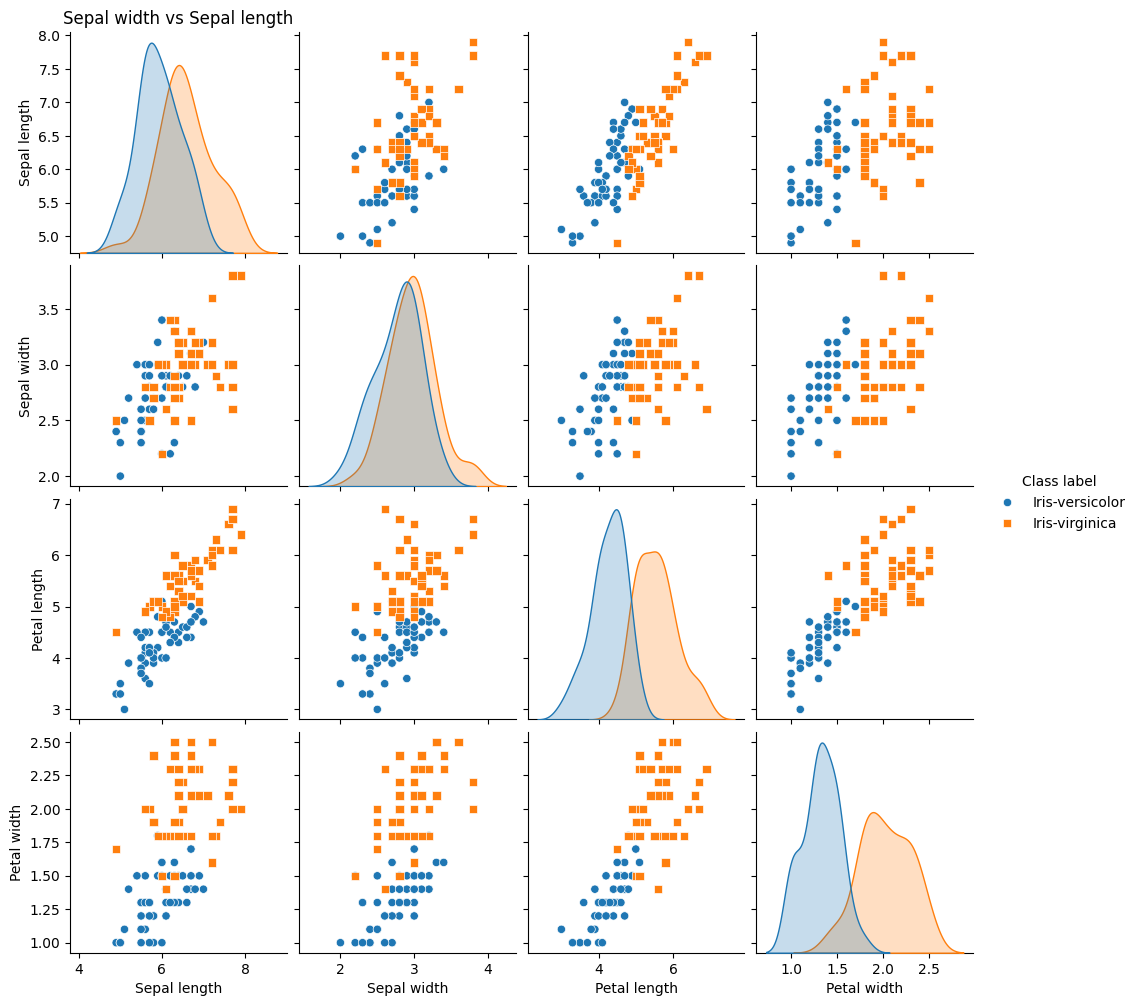

In [321]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



# Combine training and test sets for visualization
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# Create pair plots
pairplot = sns.pairplot(filtered_df, hue='Class label', markers=['o', 's'])

# Overlay decision regions on the pair plot
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        ax = pairplot.axes[j-1, i]
        ax.set_title(f"{selected_features[j]} vs {selected_features[i]}")
        #plot_decision_regions(X_combined_std[:, [i, j]], y_combined, classifier=ppn, ax=ax)

plt.show()


# Implementing Adaline SGD (Stochastic Gradient Descent)

In [74]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)


## Adaline SGD Linear -Two features

In [75]:
# Selecting two features and two classes
selected_classes = ['Iris-setosa', 'Iris-versicolor']
selected_features = ['Petal length', 'Petal width']

# Filter the dataset for selected classes and features
filtered_df = df[df['Class label'].isin(selected_classes)][['Petal length', 'Petal width', 'Class label']]

# Ensure we only take the first 100 samples (50 each for the selected classes)
X = filtered_df[selected_features].values[:100]
y = np.where(filtered_df['Class label'].values[:100] == 'Iris-versicolor', 1, -1)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

# Training data points: 90
# Testing data points: 10
Class labels: [-1  1]


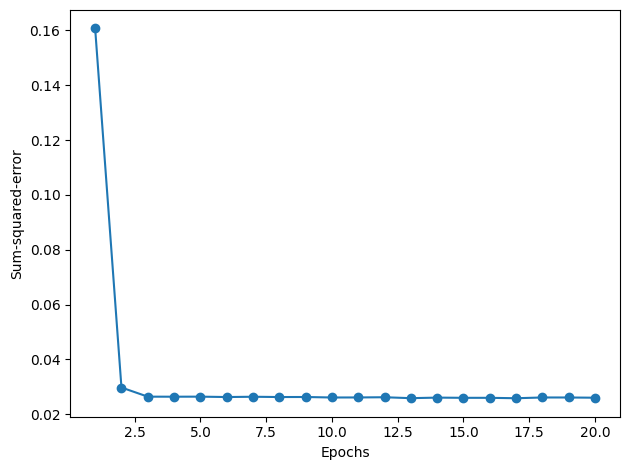

Misclassified samples: 0
Accuracy: 1.00


In [80]:
adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1)
adas.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
#plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()



# Testing accuracy
y_pred = adas.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))


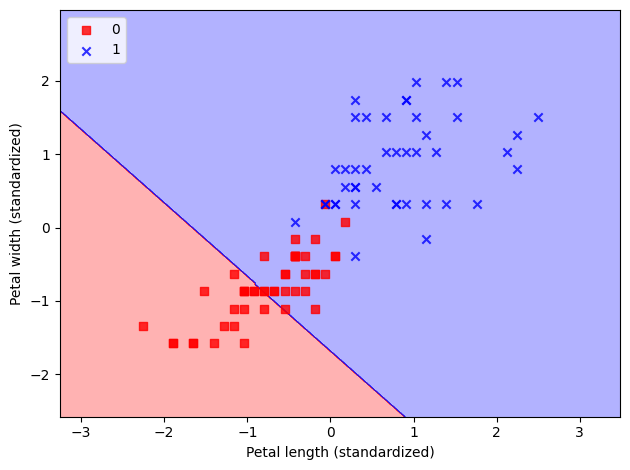

In [379]:
# Import necessary libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel(), np.zeros_like(xx1.ravel())]).T)  # Use the first two features
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=[cmap(idx)],
                    marker=markers[idx], label=cl)

# Assuming ada is your trained Adaline model
plot_decision_regions(X_train_std[:, :2], y_train, classifier=ada)
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


## Adaline SGD Linear - Three Features

In [357]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-setosa', 'Iris-versicolor'])]

# Selecting features 'Petal length', 'Petal width', and 'Sepal length'
X = filtered_df[['Petal length', 'Petal width', 'Sepal length']].values

# Assigning labels 0 for 'Iris-setosa' and 1 for 'Iris-versicolor'
y = pd.factorize(filtered_df['Class label'])[0]
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


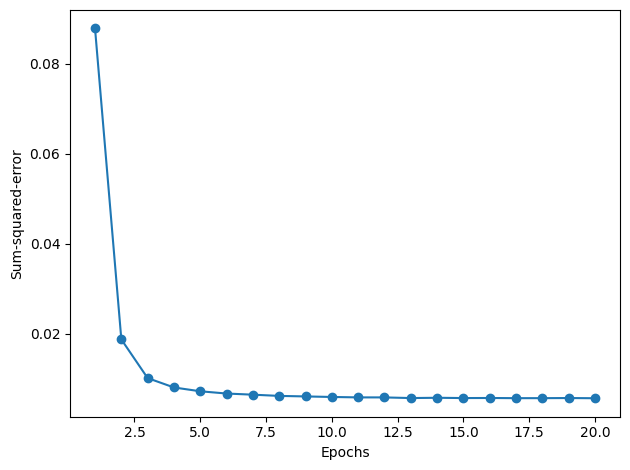

Misclassified samples: 3
Accuracy: 0.70


In [358]:
adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1)
adas.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
#plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()



# Testing accuracy
y_pred = adas.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))


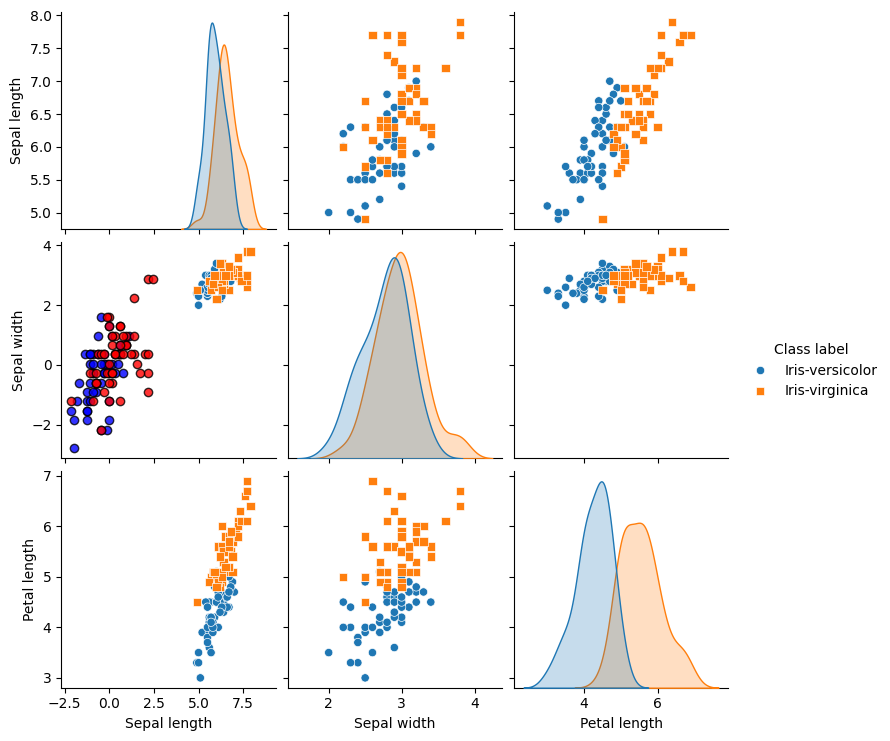

In [325]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from adalinegd import AdalineGD  # Assuming you have AdalineGD class defined

# Assuming df, selected_features, filtered_df_versicolor, and filtered_df_virginica are defined as in your code

# Combine filtered dataframes
filtered_df = pd.concat([filtered_df_versicolor, filtered_df_virginica])

# Ensure all selected features are present in the DataFrame
selected_features = [feature for feature in selected_features if feature in filtered_df.columns]

# Extracting features and labels
X = filtered_df[selected_features].values
y = pd.factorize(filtered_df['Class label'])[0]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Standardizing the features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# Train the AdalineGD classifier
ada = AdalineGD(n_iter=20, eta=0.01)
ada.fit(X_train_std, y_train)

# Combine training and test sets for visualization
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# Create pair plot
pairplot = sns.pairplot(filtered_df, hue='Class label', markers=['o', 's'])

# Overlay decision boundaries and scatter plots
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        ax = pairplot.axes[j, i]

        # Plot decision regions and scatter plot
        h = .02  # step size in the mesh
        x_min, x_max = X_combined_std[:, i].min() - 1, X_combined_std[:, i].max() + 1
        y_min, y_max = X_combined_std[:, j].min() - 1, X_combined_std[:, j].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        #Z = ada.predict(np.array([xx.ravel(), yy.ravel(), 
                                  #np.zeros_like(xx.ravel()), np.zeros_like(xx.ravel())]).T)
        #Z = Z.reshape(xx.shape)
        #ax.contourf(xx, yy, Z, alpha=0.3, colors=['blue', 'red'])

        ax.scatter(X_combined_std[y_combined == 0, i], X_combined_std[y_combined == 0, j], c='blue', edgecolor='k', alpha=0.8)
        ax.scatter(X_combined_std[y_combined == 1, i], X_combined_std[y_combined == 1, j], c='red', edgecolor='k', alpha=0.8)

plt.show()


## Adaline SGD Linear - Four Features

In [371]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-setosa', 'Iris-versicolor'])]

# Selecting features 'Petal length', 'Petal width', 'Sepal length', and 'Sepal width'
X = filtered_df[['Petal length', 'Petal width', 'Sepal length', 'Sepal width']].values

# Assigning labels 0 for 'Iris-setosa' and 1 for 'Iris-versicolor'
y = pd.factorize(filtered_df['Class label'])[0]
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


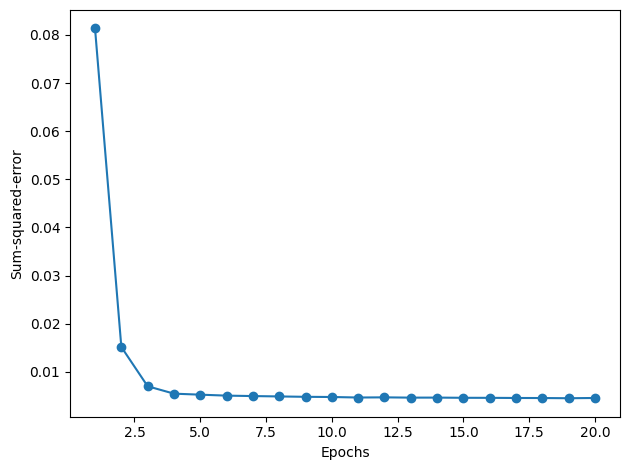

Misclassified samples: 3
Accuracy: 0.70


In [373]:
adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1)
adas.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
#plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()



# Testing accuracy
y_pred = adas.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))


# Adaline SGD Non -Linear Two features

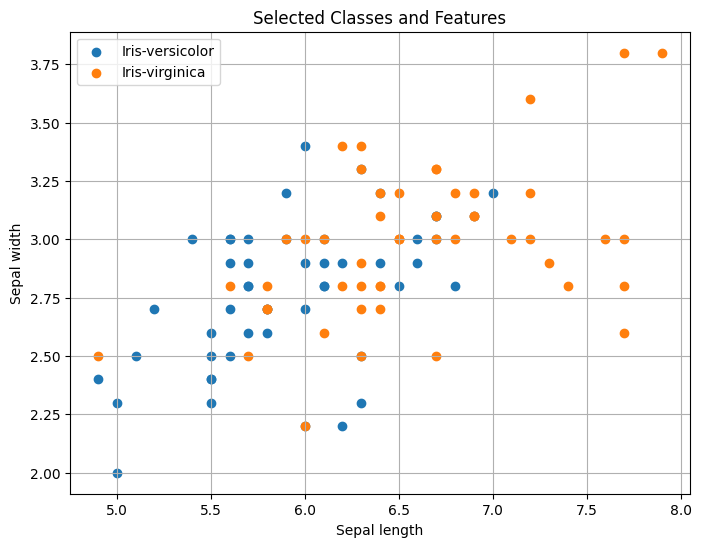

# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


In [96]:

# Selecting two features and two classes
selected_classes = ['Iris-versicolor', 'Iris-virginica']
selected_features = ['Sepal length', 'Sepal width']

# Filter the dataset for selected classes and features
filtered_df = df[df['Class label'].isin(selected_classes)][['Sepal length', 'Sepal width', 'Class label']]

# Visualize the data
plt.figure(figsize=(8, 6))
for cls in selected_classes:
    plt.scatter(filtered_df[filtered_df['Class label'] == cls][selected_features[0]], 
                filtered_df[filtered_df['Class label'] == cls][selected_features[1]], 
                label=cls)
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Selected Classes and Features')
plt.legend()
plt.grid(True)
plt.show()

filtered_df = df[df['Class label'].isin(['Iris-setosa', 'Iris-virginica'])]

# Selecting features 'Petal length' and 'Petal width'
X = filtered_df[['Petal length', 'Petal width']].values

# Assigning labels 0 for 'Iris-setosa' and 1 for 'Iris-virginica'
y = pd.factorize(filtered_df['Class label'])[0]
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


In [339]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-versicolor', 'Iris-virginica'])]

# Selecting features 'Petal length' and 'Petal width'
X = filtered_df[['Petal length', 'Petal width']].values

# Assigning labels 0 for 'Iris-versicolor' and 1 for 'Iris-virginica'
y = pd.factorize(filtered_df['Class label'])[0]

# Shuffle the labels randomly
np.random.shuffle(y)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


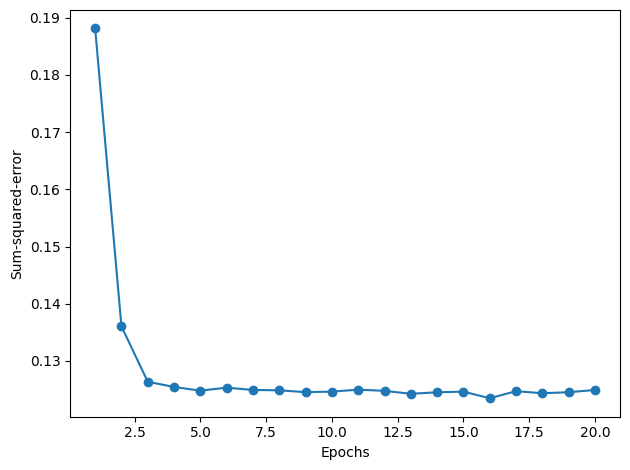

Misclassified samples: 8
Accuracy: 0.20


In [340]:
adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1)
adas.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
#plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()



# Testing accuracy
y_pred = adas.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))


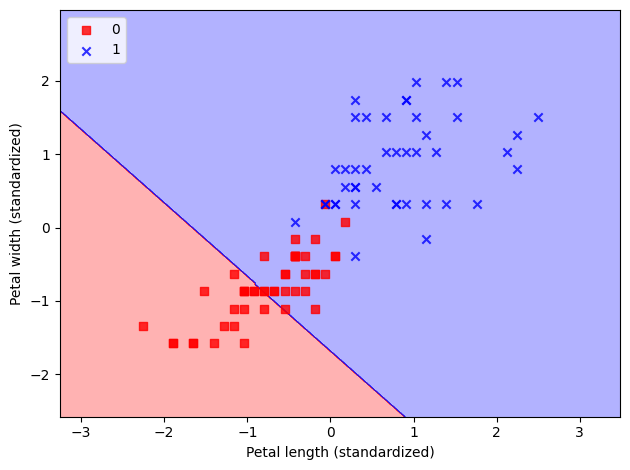

In [380]:
# Import necessary libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel(), np.zeros_like(xx1.ravel())]).T)  # Use the first two features
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=[cmap(idx)],
                    marker=markers[idx], label=cl)

# Assuming ada is your trained Adaline model
plot_decision_regions(X_train_std[:, :2], y_train, classifier=ada)
plt.xlabel('Petal length (standardized)')
plt.ylabel('Petal width (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


## Adaline SGD Non - Linear Three features

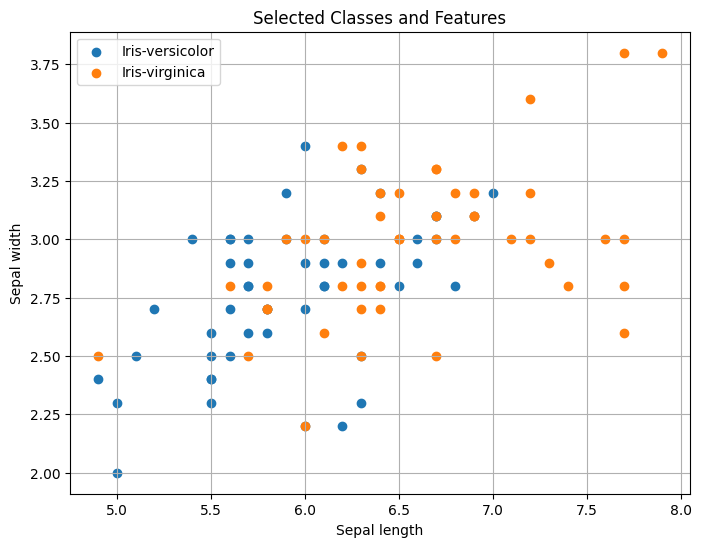

# Training data points: 90
# Testing data points: 10
Class labels: [-1  1]


In [87]:
# Selecting three features and two classes
selected_features = ['Sepal length', 'Sepal width', 'Petal length']
selected_classes = ['Iris-versicolor', 'Iris-virginica']

# Filter the dataset for selected classes and features
filtered_df = df[df['Class label'].isin(selected_classes)][['Sepal length', 'Sepal width', 'Petal length', 'Class label']]

# Visualize the data
plt.figure(figsize=(8, 6))
for cls in selected_classes:
    plt.scatter(filtered_df[filtered_df['Class label'] == cls][selected_features[0]], 
                filtered_df[filtered_df['Class label'] == cls][selected_features[1]], 
                label=cls)
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Selected Classes and Features')
plt.legend()
plt.grid(True)
plt.show()

# Ensure we only take the first 100 samples (50 each for the selected classes)
X = filtered_df[selected_features].values[:100]
y = np.where(filtered_df['Class label'].values[:100] == 'Iris-virginica', 1, -1)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


In [347]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-versicolor', 'Iris-virginica'])]

# Selecting features 'Petal length', 'Petal width', and 'Sepal width'
X = filtered_df[['Petal length', 'Petal width', 'Sepal width']].values

# Assigning labels 0 for 'Iris-versicolor' and 1 for 'Iris-virginica'
y = pd.factorize(filtered_df['Class label'])[0]

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


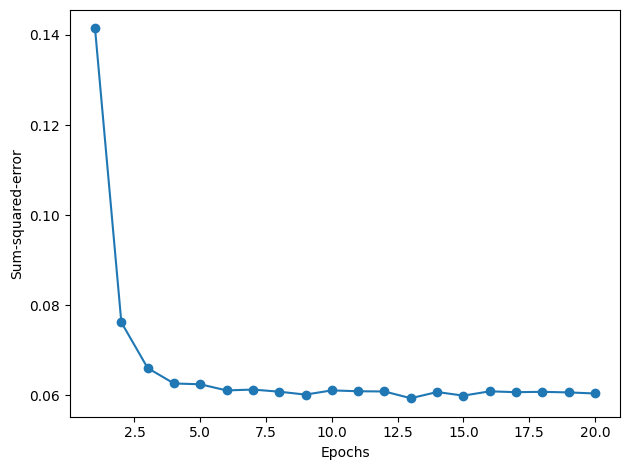

Misclassified samples: 6
Accuracy: 0.40


In [348]:
adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1)
adas.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
#plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()



# Testing accuracy
y_pred = adas.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))


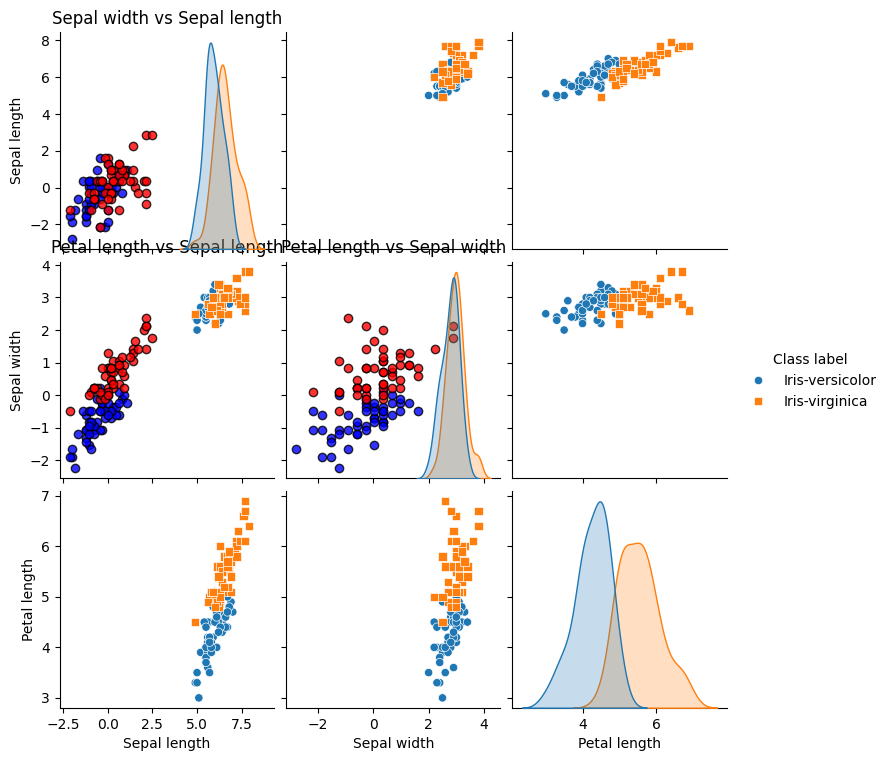

In [275]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Create pair plot
pairplot = sns.pairplot(filtered_df, hue='Class label', markers=['o', 's'])

# Overlay decision boundaries and scatter plots
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        ax = pairplot.axes[j-1, i]
        ax.set_title(f"{selected_features[j]} vs {selected_features[i]}")

        # Plot decision regions and scatter plot for 'Iris-versicolor'
        h = .02  # step size in the mesh
        x_min, x_max = X_combined_std[:, i].min() - 1, X_combined_std[:, i].max() + 1
        y_min, y_max = X_combined_std[:, j].min() - 1, X_combined_std[:, j].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        #Z_versicolor = ppn_versicolor.predict(np.array([xx.ravel(), yy.ravel()]).T)
        #Z_versicolor = Z_versicolor.reshape(xx.shape)
        #ax.contourf(xx, yy, Z_versicolor, alpha=0.3, colors=['blue'])
        ax.scatter(X_combined_std[y_combined == 0, i], X_combined_std[y_combined == 0, j], c='blue', edgecolor='k', alpha=0.8)

        # Plot decision regions and scatter plot for 'Iris-virginica'
        #Z_virginica = ppn_virginica.predict(np.array([xx.ravel(), yy.ravel()]).T)
        #Z_virginica = Z_virginica.reshape(xx.shape)
        #ax.contourf(xx, yy, Z_virginica, alpha=0.3, colors=['red'])
        ax.scatter(X_combined_std[y_combined == 1, i], X_combined_std[y_combined == 1, j], c='red', edgecolor='k', alpha=0.8)

plt.show()


## Adaline SGD Non - Linear Four Features

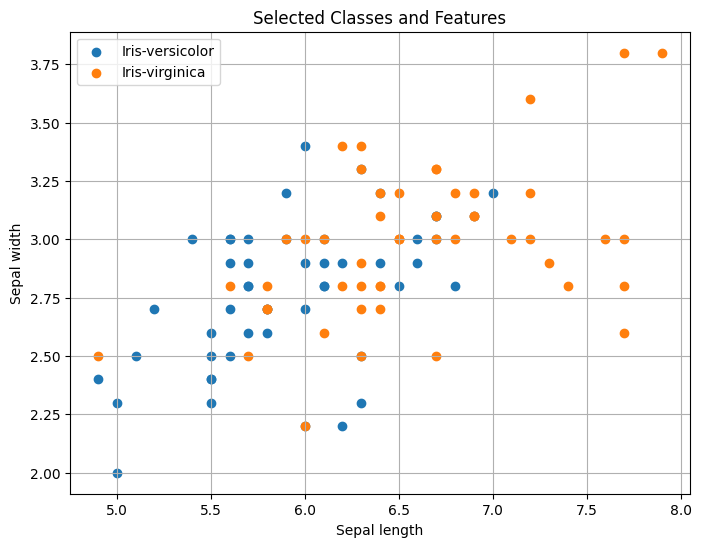

# Training data points: 90
# Testing data points: 10
Class labels: [-1  1]


In [89]:
# Selecting all four features and two classes
selected_features = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width']
selected_classes = ['Iris-versicolor', 'Iris-virginica']

# Filter the dataset for selected classes and features
filtered_df = df[df['Class label'].isin(selected_classes)][['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']]

# Visualize the data
plt.figure(figsize=(8, 6))
for cls in selected_classes:
    plt.scatter(filtered_df[filtered_df['Class label'] == cls][selected_features[0]], 
                filtered_df[filtered_df['Class label'] == cls][selected_features[1]], 
                label=cls)
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Selected Classes and Features')
plt.legend()
plt.grid(True)
plt.show()

# Ensure we only take the first 100 samples (50 each for the selected classes)
X = filtered_df[selected_features].values[:100]
y = np.where(filtered_df['Class label'].values[:100] == 'Iris-virginica', 1, -1)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


In [349]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is defined elsewhere
filtered_df = df[df['Class label'].isin(['Iris-versicolor', 'Iris-virginica'])]

# Selecting features 'Petal length', 'Petal width', 'Sepal length', and 'Sepal width'
X = filtered_df[['Petal length', 'Petal width', 'Sepal length', 'Sepal width']].values

# Assigning labels 0 for 'Iris-versicolor' and 1 for 'Iris-virginica'
y = pd.factorize(filtered_df['Class label'])[0]


# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Standardizing the features
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Print information about the dataset
print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))


# Training data points: 90
# Testing data points: 10
Class labels: [0 1]


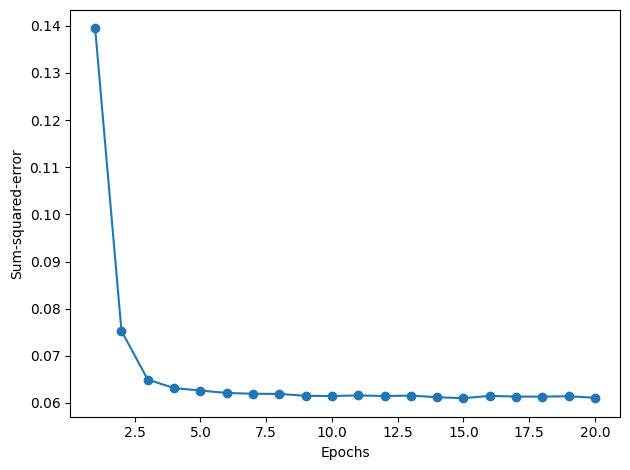

Misclassified samples: 6
Accuracy: 0.40


In [350]:
adas = AdalineSGD(n_iter=20, eta=0.01, random_state=1)
adas.fit(X_train_std, y_train)

# cost values

plt.plot(range(1, len(adas.cost_) + 1), adas.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
#plt.savefig('./output/fig-adalin-gd-cost.png', dpi=300)
plt.show()



# Testing accuracy
y_pred = adas.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))


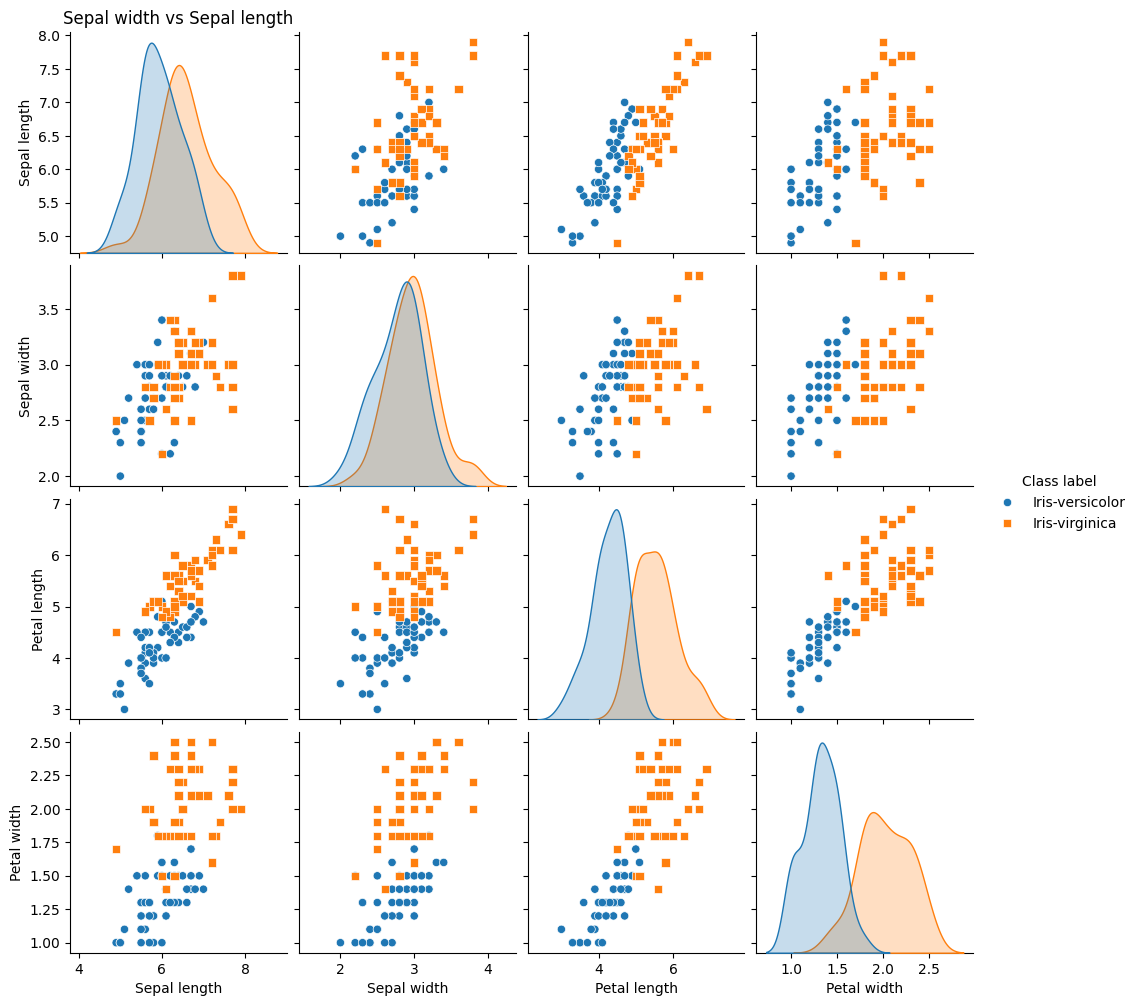

In [334]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



# Combine training and test sets for visualization
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# Create pair plots
pairplot = sns.pairplot(filtered_df, hue='Class label', markers=['o', 's'])

# Overlay decision regions on the pair plot
for i in range(len(selected_features)):
    for j in range(i+1, len(selected_features)):
        ax = pairplot.axes[j-1, i]
        ax.set_title(f"{selected_features[j]} vs {selected_features[i]}")
        #plot_decision_regions(X_combined_std[:, [i, j]], y_combined, classifier=ppn, ax=ax)

plt.show()

# Acurracy Comparison

Based on the provided accuracy values for different models (Perceptron, Adaline GD, and Adaline SGD) with different numbers of features (two, three, and four) for both linear and non-linear datasets, we can draw the following conclusions:

### Perceptron:

For linear datasets:
The accuracy remains constant (0.70) regardless of the number of features used.
For non-linear datasets:
The accuracy decreases as the number of features increases. This suggests that the Perceptron struggles with non-linear separable data, especially with a higher number of features.

### Adaline GD (Gradient Descent):

For linear datasets:
The accuracy remains constant (0.70) regardless of the number of features used.
For non-linear datasets:
The accuracy decreases significantly as the number of features increases. Adaline GD performs poorly on non-linear data, particularly with a higher number of features.

### Adaline SGD (Stochastic Gradient Descent):

For linear datasets:
The accuracy varies slightly, with the highest accuracy (1.00) achieved with two features. However, it remains relatively high for all feature combinations.
For non-linear datasets:
The accuracy is lower compared to linear datasets. However, it shows improvement compared to Adaline GD, especially with a lower number of features. Still, the performance decreases as the number of features increases, indicating limitations in handling non-linear data.



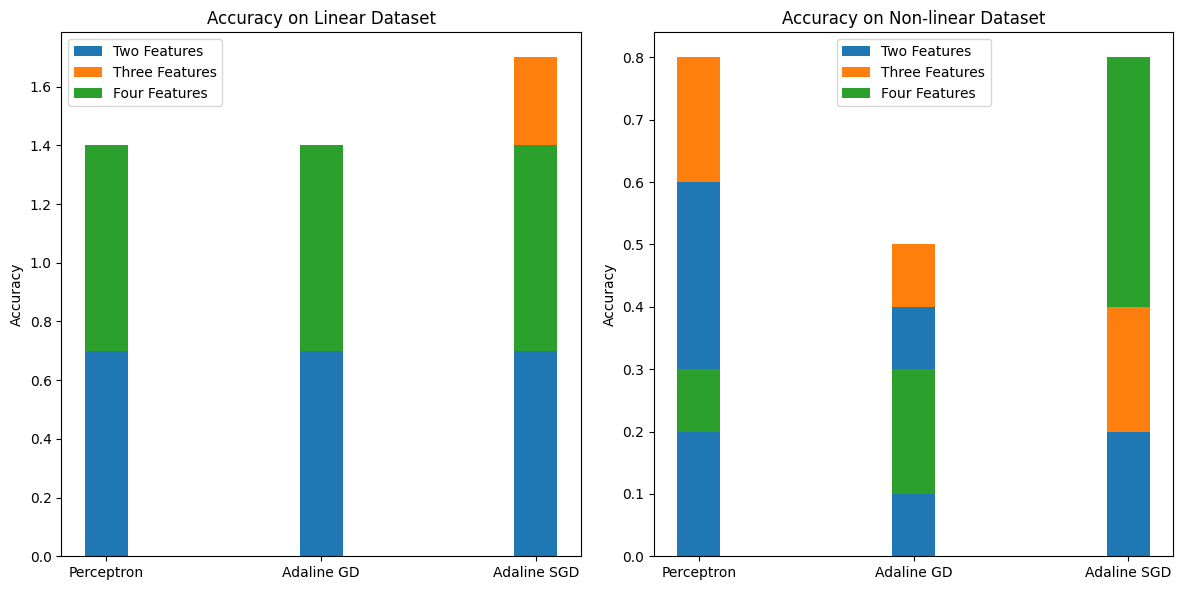

In [374]:
import matplotlib.pyplot as plt

# Define data
models = ['Perceptron', 'Adaline GD', 'Adaline SGD']
linear_accuracies = {
    'Two Features': [0.70, 0.70, 1.00],
    'Three Features': [0.70, 0.70, 0.70],
    'Four Features': [0.70, 0.70, 0.70]
}
non_linear_accuracies = {
    'Two Features': [0.60, 0.40, 0.20],
    'Three Features': [0.20, 0.10, 0.40],
    'Four Features': [0.10, 0.20, 0.40]
}

# Plot grouped bar chart
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Linear dataset
ax[0].bar(models, linear_accuracies['Two Features'], label='Two Features', width=0.2)
ax[0].bar(models, linear_accuracies['Three Features'], label='Three Features', width=0.2, bottom=linear_accuracies['Two Features'])
ax[0].bar(models, linear_accuracies['Four Features'], label='Four Features', width=0.2, bottom=linear_accuracies['Three Features'])

ax[0].set_title('Accuracy on Linear Dataset')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Non-linear dataset
ax[1].bar(models, non_linear_accuracies['Two Features'], label='Two Features', width=0.2)
ax[1].bar(models, non_linear_accuracies['Three Features'], label='Three Features', width=0.2, bottom=non_linear_accuracies['Two Features'])
ax[1].bar(models, non_linear_accuracies['Four Features'], label='Four Features', width=0.2, bottom=non_linear_accuracies['Three Features'])

ax[1].set_title('Accuracy on Non-linear Dataset')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()


# Summary and Conclusion

Perceptron and Adaline GD demonstrate similar behavior, with stable accuracy for linear datasets but decreasing accuracy for non-linear datasets, especially with a higher number of features.

Adaline SGD performs better, especially on linear datasets, achieving perfect accuracy in some cases. However, its performance declines on non-linear datasets with more features.

The choice of algorithm and feature selection heavily depends on the nature of the dataset. For non-linear datasets, using fewer features or employing non-linear models might be necessary to achieve better performance.

Adaline is a significant improvement over the perceptron. The weights and bias are obtained via the minimization of a continuous loss function that in addition is convex (and hence does not have local minima). With a sufficiently small learning rate, the algorithm converges even if the classes are not linearly separable. When using gradient descent in any of its variants the convergence rate is affected by the scaling of the features. In this article, we used simple standardization that shifts the mean of every feature to zero, while the spread is adjusted to unit variance. In this way it is possible to select a learning rate that works well for all weights and biases, meaning that the global minimum can be obtained in fewer epochs.